In [1]:
include("../source/spin-1_XY_ED.jl")

odlro_matrix (generic function with 1 method)

#### 1) Fidelity when $ J_2 = 0 $ 

In [2]:
N = 6
J1,J3,D,h = 1.0,0.1,0.1,1.0
boundary = "OBC"
use_sparse = false
mz = 0

@time begin
    nearest_bond_list = gen_bonds_1D(N,boundary)
    third_nbr_bond_list = gen_3rd_nbr_bonds_1D(N,boundary)
    basis_list = gen_basis_full_1D(N)
#     neel_state = nematic_neel_1D(N,basis_list)
#     ferro_state = nematic_ferro_1D(N,basis_list)
#     target_state = [i % 3 == 1 ? 1 : i % 3 == 2 ? 0 : -1 for i in 1:N]
#     prod_state::Vector{Float64} = [basis == target_state ? 1.0 : 0.0 for basis in basis_list]
#     prod_state = prod_state/norm(prod_state)
    basis_new1 = similar(basis_list[1])
    basis_new2 = similar(basis_list[1])
    H_XY,H_size = Ham_XY_1D(J1,J3,D,h,N,basis_list,basis_new1,basis_new2,nearest_bond_list,
                            third_nbr_bond_list,use_sparse)  
end;

  0.176398 seconds (314.70 k allocations: 25.697 MiB, 95.39% compilation time)


In [45]:
@time energy,eigenvector = eigen(H_XY);

  0.127223 seconds (16 allocations: 12.426 MiB)


In [46]:
for (pos1,E1) in enumerate(energy)
    for (pos2,E2) in enumerate(energy)
        if (pos1 != pos2) && (round(E1,digits=6) == round(E2,digits=6))
            println(E1," ",pos1," ",pos2)
        end
    end
end

In [22]:
time_list = Vector{Float64}((LinRange(0,20,400)))
n_t = length(time_list)
t_step = time_list[2]-time_list[1]
evolved_neel_state_list::Vector{Vector{ComplexF64}} = Vector{Vector{ComplexF64}}(undef,n_t)
evolved_prod_state_list::Vector{Vector{ComplexF64}} = Vector{Vector{ComplexF64}}(undef,n_t)
evolved_ferro_state_list::Vector{Vector{ComplexF64}} = Vector{Vector{ComplexF64}}(undef,n_t)
exp_H::Matrix{ComplexF64} = Matrix{ComplexF64}(undef,H_size,H_size)
evolved_state::Vector{ComplexF64} = Vector{ComplexF64}(undef,H_size)
eigenvector_inv::Matrix{Float64} = inv(eigenvector)

@time begin
    for i in 1:n_t
        t = time_list[i]  
        evolved_neel_state_list[i] = copy(state_evolution(exp_H,energy,eigenvector,eigenvector_inv,t,
                                                    neel_state,evolved_state))
        evolved_ferro_state_list[i] = copy(state_evolution(exp_H,energy,eigenvector,eigenvector_inv,t,
                                                    ferro_state,evolved_state))
        evolved_prod_state_list[i] = copy(state_evolution(exp_H,energy,eigenvector,eigenvector_inv,t,
                                            prod_state,evolved_state))
    end
end;

LoadError: UndefVarError: `neel_state` not defined

In [5]:
neel_fidelity_list::Vector{Float64} = Vector{Float64}(undef,n_t)
ferro_fidelity_list::Vector{Float64} = Vector{Float64}(undef,n_t)
prod_fidelity_list::Vector{Float64} = Vector{Float64}(undef,n_t)

@time begin
    for i in 1:n_t
            neel_t_evolved_state = evolved_neel_state_list[i]
            neel_fidelity_list[i] = abs2(dot(neel_state,neel_t_evolved_state))
            ferro_t_evolved_state = evolved_ferro_state_list[i]
            ferro_fidelity_list[i] = abs2(dot(ferro_state,ferro_t_evolved_state))
            prod_t_evolved_state = evolved_prod_state_list[i]
            prod_fidelity_list[i] = abs2(dot(prod_state,prod_t_evolved_state))
    end
end;

  0.045841 seconds (12.28 k allocations: 766.586 KiB, 93.34% compilation time)


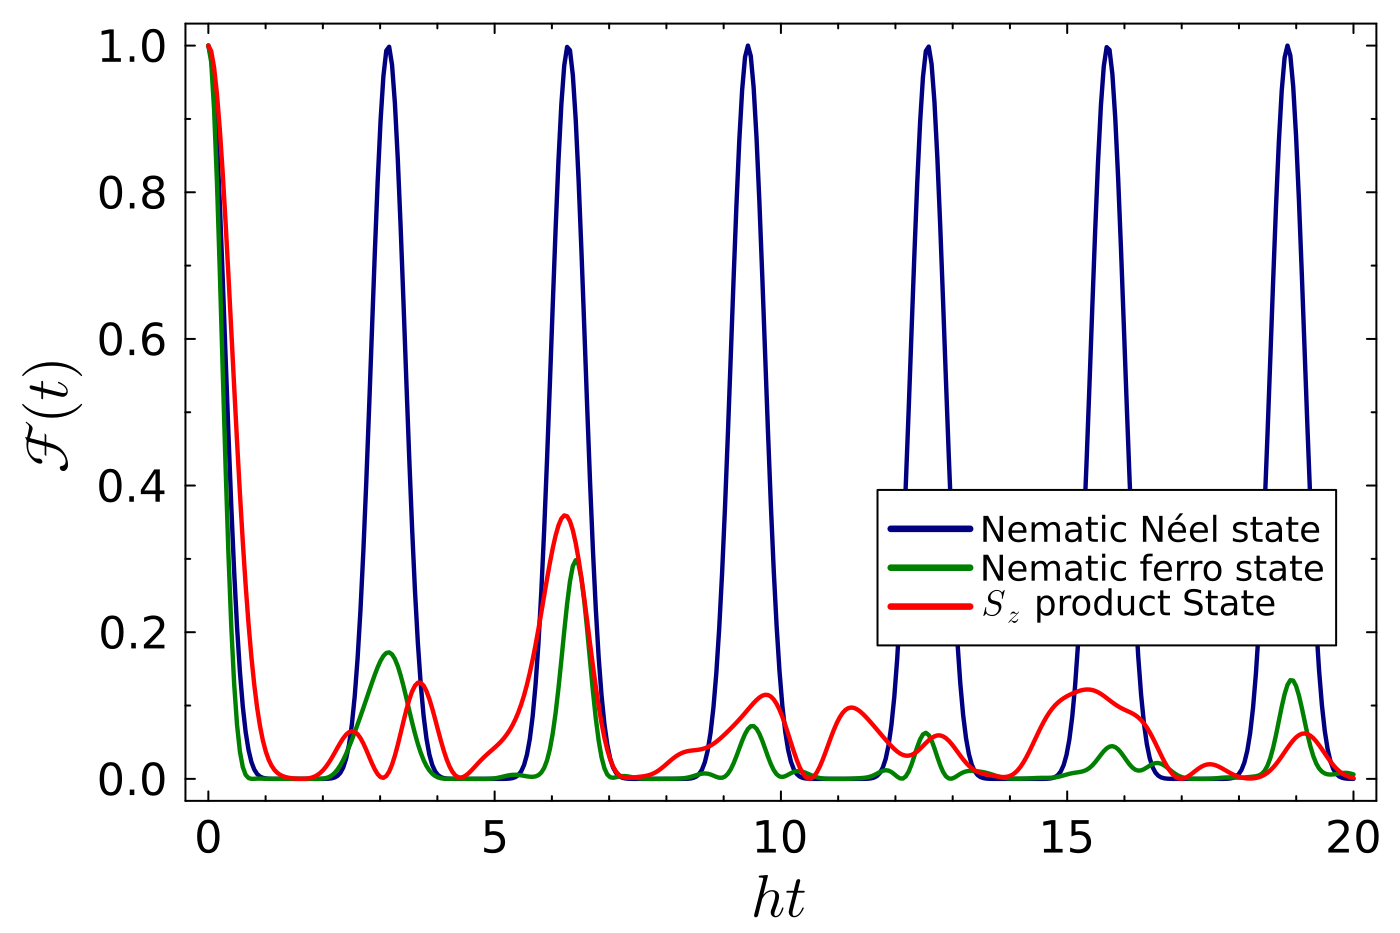

In [7]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

plot_size = (700,466.67)

p = plot(h*time_list,neel_fidelity_list,lw=2.2,c=:navy,label="Nematic Néel state",size=plot_size,dpi=200)
plot!(h*time_list,ferro_fidelity_list,lw=2.2,c=:green,label="Nematic ferro state")
plot!(h*time_list,prod_fidelity_list,lw=2.2,c=:red,label="\$S_z\$ product State")

plot!(left_margin=4mm,right_margin=1mm,top_margin=1mm,bottom_margin=2mm)
plot!(framestyle=:box)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)
plot!(legend_position=(0.67,0.35),legendfontsize=12,legend_background_color=:white,legend_foreground_color=:black)

xlabel!(L"ht",guidefontsize=20)
ylabel!(L"\mathcal{F}(t)",guidefontsize=20)
title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x1,x_step,x2 = 0,10,40
y1,y_step,y2 = 0.0,0.2,1.0
xticks = (x1:x_step:x2,string.(x1:x_step:x2))
yticks = (y1:y_step:y2,string.(y1:y_step:y2))
xminor_ticks = 5 
yminor_ticks = 2
plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
      xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:in)
plot!(xlims=(-0.4,x2+0.4))

folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\unperturbed\\$(boundary)"
if !isdir(folder_name)
    mkpath(folder_name)
end

file_path = joinpath(folder_name,"Fidelity_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)

#### 2) Fidelity when $ J_2 \neq 0 $ 

In [8]:
N = 6
J1,J3,D,h = 1.0,0.1,0.1,1.0
J2 = 0.05
boundary = "OBC"
use_sparse = false

@time begin
    nearest_bond_list = gen_bonds_1D(N,boundary)
    third_nbr_bond_list = gen_3rd_nbr_bonds_1D(N,boundary)
    sec_nbr_bond_list = gen_2nd_nbr_bonds_1D(N,boundary)
    basis_list = gen_basis_full_1D(N)
    ref_state = nematic_neel_1D(N,basis_list)
    basis_new1 = similar(basis_list[1])
    basis_new2 = similar(basis_list[1])
    H_XY,H_size = Ham_XY_1D(J1,J3,D,h,N,basis_list,basis_new1,basis_new2,nearest_bond_list,
                            third_nbr_bond_list,use_sparse)
    H_sec_nbr,H_size = Ham_2nd_nbr_1D(J2,N,basis_list,basis_new1,sec_nbr_bond_list,use_sparse)
    H_total = H_XY + H_sec_nbr
end;
println(H_size)

  0.014719 seconds (31.48 k allocations: 14.440 MiB)
729


In [9]:
@time energy,eigenvector = eigen(H_total);

  0.145696 seconds (16 allocations: 12.426 MiB, 4.58% gc time)


In [11]:
time_list = Vector{Float64}((LinRange(0,40,400)))
n_t = length(time_list)
t_step = time_list[2]-time_list[1]
evolved_neel_state_list::Vector{Vector{ComplexF64}} = Vector{Vector{ComplexF64}}(undef,n_t)
evolved_prod_state_list::Vector{Vector{ComplexF64}} = Vector{Vector{ComplexF64}}(undef,n_t)
evolved_ferro_state_list::Vector{Vector{ComplexF64}} = Vector{Vector{ComplexF64}}(undef,n_t)
exp_H::Matrix{ComplexF64} = Matrix{ComplexF64}(undef,H_size,H_size)
evolved_state::Vector{ComplexF64} = Vector{ComplexF64}(undef,H_size)
eigenvector_inv::Matrix{Float64} = inv(eigenvector)

@time begin
    for i in 1:n_t
        t = time_list[i]  
        evolved_neel_state_list[i] = copy(state_evolution(exp_H,energy,eigenvector,eigenvector_inv,t,
                                                    neel_state,evolved_state))
        evolved_ferro_state_list[i] = copy(state_evolution(exp_H,energy,eigenvector,eigenvector_inv,t,
                                                    ferro_state,evolved_state))
        evolved_prod_state_list[i] = copy(state_evolution(exp_H,energy,eigenvector,eigenvector_inv,t,
                                            prod_state,evolved_state))
    end
end;

 51.304005 seconds (9.20 k allocations: 19.046 GiB, 6.12% gc time)


In [12]:
neel_fidelity_list::Vector{Float64} = Vector{Float64}(undef,n_t)
ferro_fidelity_list::Vector{Float64} = Vector{Float64}(undef,n_t)
prod_fidelity_list::Vector{Float64} = Vector{Float64}(undef,n_t)

@time begin
    for i in 1:n_t
            neel_t_evolved_state = evolved_neel_state_list[i]
            neel_fidelity_list[i] = abs2(dot(neel_state,neel_t_evolved_state))
            ferro_t_evolved_state = evolved_ferro_state_list[i]
            ferro_fidelity_list[i] = abs2(dot(ferro_state,ferro_t_evolved_state))
            prod_t_evolved_state = evolved_prod_state_list[i]
            prod_fidelity_list[i] = abs2(dot(prod_state,prod_t_evolved_state))
    end
end;

  0.003347 seconds (2.80 k allocations: 68.781 KiB)


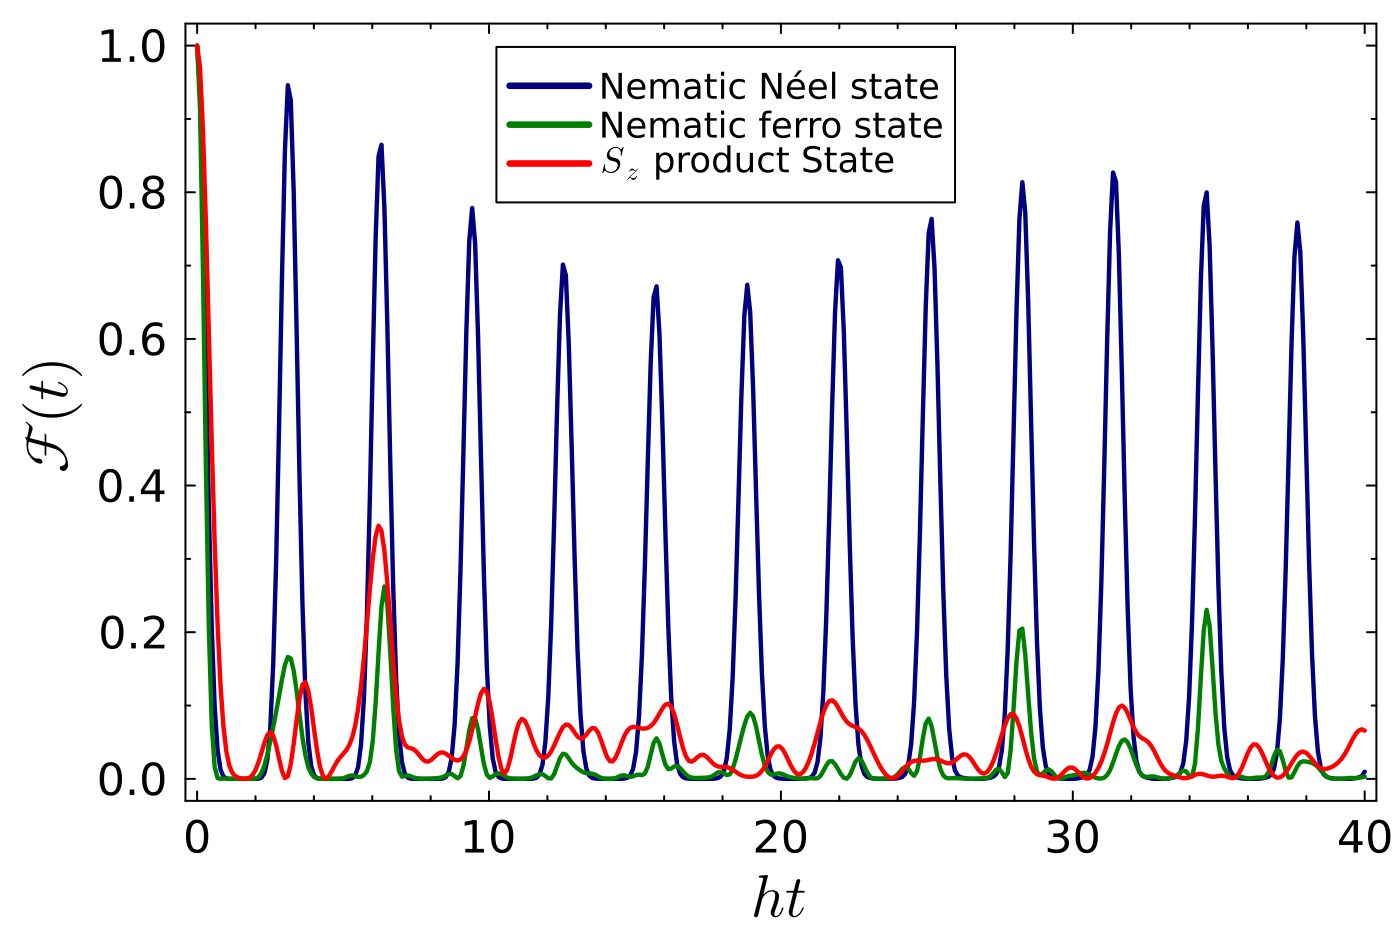

"D:\\IACS_Project\\spin-1_XY\\Plots\\1D\\spin-1_XY_N=6\\sec_nbr_perturbed\\OBC\\Fidelity_g=0.05_J3=0.1_D=0.1_h=1.0.png"

In [19]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

# Set the figure size
plot_size = (700,466.67)

# Define the plot
p = plot(h*time_list,neel_fidelity_list,lw=2.2,c=:navy,label="Nematic Néel state",size=plot_size,dpi=200)
plot!(h*time_list,ferro_fidelity_list,lw=2.2,c=:green,label="Nematic ferro state")
plot!(h*time_list,prod_fidelity_list,lw=2.2,c=:red,label="\$S_z\$ product State")

plot!(left_margin=4mm,right_margin=1mm,top_margin=1mm,bottom_margin=2mm)
plot!(framestyle=:box)
plot!(legend_position=(0.35,0.92),legendfontsize=12,legend_background_color=:white,legend_foreground_color=:black)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)

xlabel!("\$ht\$",guidefontsize=20)
ylabel!("\$\mathcal{F}(t)\$",guidefontsize=20)
title_text = "\$ N = $N \\quad $boundary,\\ J_{2}/J_{1} = $(round(J2/J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x1,x_step,x2 = 0,10,40
y1,y_step,y2 = 0.0,0.2,1.0
xticks = (x1:x_step:x2,string.(x1:x_step:x2))
yticks = (y1:y_step:y2,string.(y1:y_step:y2))
xminor_ticks = 5 
yminor_ticks = 2
plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
      xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:in)
plot!(xlims=(-0.4,x2+0.4))

folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)"
if !isdir(folder_name)
    mkpath(folder_name)
end

file_path = joinpath(folder_name,"Fidelity_g=$(round(J2/J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)